In [1]:
# Import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import scipy.stats
import phi_divergence as phi
import time
import math
import random

In [2]:
# Matplotlib settings:
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['figure.dpi'] = 100 # can be increased for better quality

The toy model we examine is as follows:

\begin{align}\label{toy_model_2}
    \begin{split}
        \max_{\mathbf{x} \geq \mathbf{0}}\{\mathbf{e}^T \mathbf{x}: \mathbb{P}^*(\mathbf{\xi}\in [-1,1]^{k}: \mathbf{\xi}^T \mathbf{x} \leq 1)\geq \beta\}.
    \end{split}
\end{align}

In [3]:
# Problem specific functions:
def generate_data(k, N):
    np.random.seed(1)
    data = np.random.uniform(-1,1,size = (N,k)) # generates N random scenarios    
    return data 

def generate_data_with_nominal(k, N):
    data_nominal = np.array([[0] * k])
    np.random.seed(1)
    data = np.random.uniform(-1,1,size = (N-1,k)) # generate N-1 scenarios
    data = np.concatenate((data,data_nominal)) # add nominal case to training data
    return data, data_nominal

def solve_toymodel(Z_arr, k, time_limit):
    x = cp.Variable(k, nonneg = True)
    constraints = [Z_arr @ x <= 1, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    return(x.value, prob.value)

def get_true_prob(x, k):
    return(1/2+1/(2*x[k-1]))
    
def solve_toymodel_true_prob(beta, k):
    x = cp.Variable(k, nonneg = True)
    constraints = [(1-2*beta)*x[k-1] + 1 >= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

In [48]:
# Methodology-related functions:
def lowbound(p, r, par, phi_div):
    q = cp.Variable(2, nonneg = True)
    constraints = [cp.sum(q) == 1]
    constraints = phi_div(p,q,r,par,constraints)
    obj = cp.Minimize(q[0])
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value)

def add_scenarios(add_strategy, data, Z_arr, constr, vio, beta, lb):
    Z_to_add = None
    if add_strategy == 'smallest_vio':   # the least violated scenario is added
        vio_min = np.min(vio)        
        ind = np.where(constr == vio_min)[0][0]
        Z_to_add = np.array([data[ind]])
    elif add_strategy == 'N*(beta-lb)_smallest':   # the N*(beta-lb)-th scenario is added
        rank = np.ceil(len(data)*(beta-lb)).astype(int)
        vio_sort = np.sort(vio) 
        vio_value = vio_sort[rank-1]     # -1 to correct for python indexing
        ind = np.where(constr == vio_value)[0][0]  
        Z_to_add = np.array([data[ind]])
    elif add_strategy == 'random_vio':
        #i_vio_rand = random.randrange(len(vio))
        #vio_rand = vio[i_vio_rand]
        #ind = np.where(contr == vio_rand)[0][0]
        ind = np.random.choice(np.where(constr > (1+numeric_precision))[0])
        Z_to_add = np.array([data[ind]])
    else:
        print("Error: did not provide valid addition strategy")
        
    Z_arr = np.append(Z_arr, Z_to_add, axis = 0)
    return Z_arr

def remove_scenarios(remove_strategy, Z_arr, x, numeric_precision):
    if remove_strategy == 'all_inactive':
        constr_Z = Z_arr.dot(x)
        Z_arr = np.delete(Z_arr, np.where(constr_Z < (1-numeric_precision)), axis=0)
    elif remove_strategy == 'random_active':
        constr_Z = Z_arr.dot(x)
        active = np.where(constr_Z >= (1-numeric_precision))[0]
        random_active = np.random.choice(active)
        Z_arr = np.delete(Z_arr, random_active, axis=0)
    else:
        print("Error: did not provide valid removal strategy")
    return Z_arr

def search_alg(data_nominal, data_train, beta, alpha, time_limit_search, time_limit_solve,
              add_strategy, remove_strategy, improve_strategy, par, phi_div, numeric_precision):
    start_time = time.time()
    # Set seed for random strategies
    random.seed(1)

    # Get extra info
    N_train = len(data_train)
    k = data_train.shape[1]
    r = phi_dot/(2*N_train)*scipy.stats.chi2.ppf(1-alpha, 1)
    
    # Initialize 
    Z_arr = data_nominal
    lb = -np.inf
    num_iter = 0
    solutions = []
    max_nr_solutions = 1e6 # for easy problems with long time limits, we may want extra restriction
    
    while True:
        solve_start_time = time.time()
        [x, obj] = solve_toymodel(Z_arr, k, time_limit_solve)
        solve_time = time.time() - solve_start_time
            
        # Compute the lower bound on training data (to get a feel for feasibility)
        constr = data_train.dot(x)
        vio = constr[constr>(1+numeric_precision)]   
        p_vio = len(vio)/N_train
        p = np.array([1-p_vio, p_vio])
        
        if p_vio == 0:
            lb = 1
        else:
            lb = lowbound(p, r, par, phi_div)
        
        solutions.append({'sol': x, 'obj': obj, 'time': (time.time()-start_time), 
                          'lb_train': lb, 'scenario_set': Z_arr.copy()})
                
        if len(solutions) >= max_nr_solutions:
            break
        
        if solve_time >= time_limit_solve: # Invoke removal scenarios (to improve solve efficiency)
            Z_arr = remove_scenarios(remove_strategy, Z_arr, x, numeric_precision)
        
        if lb >= beta: # have achieved feasibility, now we remove some scenarios
            Z_arr = remove_scenarios(improve_strategy, Z_arr, x, numeric_precision)
        else: # Add scenario if lb still lower than beta
            Z_arr = add_scenarios(add_strategy, data_train, Z_arr, constr, vio, beta, lb) 
        
        num_iter += 1 
        
        if (time.time()-start_time) >= time_limit_search:
            break   
    
    runtime = time.time() - start_time
    return runtime, num_iter, solutions  
    
def evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, numeric_precision):
    start_time = time.time()
    
    # Get extra info
    N_test = len(data_test)
    k = data_test.shape[1]
    r = phi_dot/(2*N_test)*scipy.stats.chi2.ppf(1-alpha, 1)
    
    # Store best solution info
    best_sol = {'sol': None}
    
    for sol_info in solutions:
        x = sol_info['sol']
        
        # Evaluate "true" lb on test data
        constr_test = data_test.dot(x)
        vio_test = constr_test[constr_test>(1+numeric_precision)]   
        p_vio = len(vio_test)/N_test
        p = np.array([1-p_vio, p_vio])
        lb = lowbound(p, r, par, phi_div)
        sol_info['lb_test'] = lb
        
        if best_sol['sol'] is None or (best_sol['lb_test'] < beta and lb > best_sol['lb_test']):
            best_sol = sol_info
        elif ((lb >= beta and sol_info['obj'] > best_sol['obj']) 
              or (lb > best_sol['lb_test'] and sol_info['obj'] >= best_sol['obj'])):
            best_sol = sol_info
    
    runtime = time.time() - start_time
    return runtime, best_sol

In [27]:
# Auxillary functions:
def compute_opt_given_data(alpha, beta, par, phi_div, data, time_limit_mosek):
    N = data.shape[0]
    M = 1000 # set M large enough such that constraint is made redundant
    p_min, lb = determine_min_p(alpha, beta, par, phi_div, N)
    
    if p_min > 1:
        return None, None, None, None, p_min
    
    F = np.ceil(p_min * N)
    start_time = time.time()
    x, y, obj = opt_set(data, F, M, time_limit_mosek)
    runtime = time.time() - start_time
    sum_y = np.sum(y)
    return runtime, x, sum_y, obj, p_min

def opt_set(data, F, M, time_limit):
    N = data.shape[0]
    k = data.shape[1]
    x = cp.Variable(k, nonneg = True)
    y = cp.Variable(N, boolean = True)
    constraints = [cp.sum(x[0:(k-1)]) <= x[k-1]-1, x <= 10, data @ x <= 1 + (1-y)*M, cp.sum(y) >= F]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    return(x.value, y.value, prob.value)

def determine_min_p(alpha, beta, par, phi_div, N):
    # "fixed" settings for this procedure
    delta = 0.1
    epsilon = 0.0001
    r = phi_dot/(2*N)*scipy.stats.chi2.ppf(1-alpha, 1)
    p = np.array([beta, 1-beta])
    lb = lowbound(p, r, par, phi_div)
    p_prev = p
    while True:
        if p[0] + delta > 1 - epsilon:
            delta = delta/10
        p = p + np.array([delta, -delta])
        lb = lowbound(p, r, par, phi_div)
        if lb < beta:
            continue
        else:
            delta = delta / 10
            if delta < epsilon:
                break
            else:
                p = p_prev 
    return p[0], lb

def check_conv_comb(Z_arr):
    conv_comb_points = []
    if len(Z_arr) >= 3:
        for i in range(len(Z_arr)):
            z_i = Z_arr[i]
            Z_rest = np.append(Z_arr[:i], Z_arr[(i+1):], axis = 0)
            # solve optimization problem, if feasible, z_i is convex combination of points in Z_rest 
            # (https://en.wikipedia.org/wiki/Convex_combination)
            alpha = cp.Variable(len(Z_rest), nonneg = True)
            constraints = [alpha @ Z_rest == z_i, cp.sum(alpha) == 1]
            obj = cp.Maximize(alpha[0]) # no true objective function, only interested whether feasible solution exists
            prob = cp.Problem(obj,constraints)
            prob.solve(solver=cp.MOSEK)
            if prob.status != 'infeasible':
                conv_comb_points.append(i) 
    return conv_comb_points

def compute_calafiore_N_min(dim_x, beta, alpha):
    N_min = np.ceil(dim_x /((1-beta)*alpha)).astype(int) - 1
    return N_min
                   
def compute_calafiore_vio_bound(N, dim_x, beta):
    bound = math.comb(N,dim_x) * ((1 - (1-beta))**(N - dim_x))
    return bound

def determine_calafiore_N_min(dim_x, beta, alpha):
    # Do bisection search between 1 and calafiore N_min
    a = 1
    f_a = compute_calafiore_vio_bound(a, dim_x, beta)
    b = compute_calafiore_N_min(dim_x, beta, alpha)
    f_b = compute_calafiore_vio_bound(b, dim_x, beta)
    while True:
        c = np.ceil((a+b)/2).astype(int)
        f_c = compute_calafiore_vio_bound(c, dim_x, beta)
        if abs(a-b) == 1:
            if f_c <= alpha:
                return c
            else:
                return c-1
        if f_c > alpha:
            a = c
            f_a = f_c
        else:
            b = c
            f_b = f_c

def compute_campi_vio_bound(N, dim_x, beta):
    bound = 0
    for i in range(dim_x):
        bound += math.comb(N,i) * ((1-beta)**i) * (1 - (1-beta))**(N - i)
    return bound
            
def determine_campi_N_min(dim_x, beta, alpha):
    # Do bisection search between 1 and calafiore N_min
    a = 1
    f_a = compute_campi_vio_bound(a, dim_x, beta)
    b = compute_calafiore_N_min(dim_x, beta, alpha)
    f_b = compute_campi_vio_bound(b, dim_x, beta)
    while True:
        c = np.ceil((a+b)/2).astype(int)
        f_c = compute_campi_vio_bound(c, dim_x, beta)   
        if abs(a-b) == 1:
            if f_c <= alpha:
                return c
            else:
                return c-1
        if f_c > alpha:
            a = c
            f_a = f_c
        else:
            b = c
            f_b = f_c
            
def solve_with_campi_N(alpha, beta, numeric_precision, data, time_limit_mosek):  
    Z_arr = data
    start_time = time.time()
    [x, obj] = solve_toymodel(Z_arr, k, time_limit_mosek)
    runtime = time.time() - start_time
    true_prob = get_true_prob(x, k)
    return runtime, x, obj, true_prob, Z_arr
    

In [28]:
# Test if calafiore and campi functions are working properly by replicating Table 2 in Campi, M. C., & Garatti, S. (2008)
dim_x = 10
campi_epsilon = [0.1, 0.05, 0.025, 0.01]#, 0.005, 0.0025, 0.001]
li_beta = [(1-eps) for eps in campi_epsilon]
alpha = 10**-5

for beta in li_beta:
    print("Epsilon: " + str(round(1-beta, 4)), end = ', ')
    N_cal = determine_calafiore_N_min(dim_x, beta, alpha)
    print("Cal: " + str(N_cal), end = ', ')
    N_campi = determine_campi_N_min(dim_x, beta, alpha)
    print("Campi: " + str(N_campi))

Epsilon: 0.1, Cal: 579, Campi: 285
Epsilon: 0.05, Cal: 1344, Campi: 581
Epsilon: 0.025, Cal: 3035, Campi: 1171
Epsilon: 0.01, Cal: 8675, Campi: 2942


In [29]:
# Display output functions:
def plot_iter(name, num_iter, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend):
    plt.plot(data[:,0],data[:,1],'ok',markersize=1, label = 'All scenarios')
    
    if Z_arr is not None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='blue', marker='+', linestyle='',
                 markersize=10, label = 'Chosen scenarios')

    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1, 1, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--r', label = r'$\xi_{1}x_{1}^{*}+\xi_{2}x_{2}^{*}\leq 1$' ,alpha=1)

    plt.title('Iteration '+str(num_iter)+': Solution = (' + str(round(x[0],3)) + ', ' 
              + str(round(x[1],3)) + '), Objective value = ' + str(round(obj,3)) 
              + ', Lower bound = '+ str(round(lb,3)))
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'Figures/ToyModel/Scenarios_wConstraint_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()
    
def plot_solution(name, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend):
    if data.shape[1] > 2:
        print("ERROR: Cannot print larger than 2 dim")
        return
    
    plt.plot(data[:,0],data[:,1],'ok',markersize=1, label = 'All scenarios')
    
    if Z_arr is not None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='blue', marker='+', linestyle='',
                 markersize=10, label = 'Chosen scenarios')

    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1, 1, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--r', label = r'$\xi_{1}x_{1}^{*}+\xi_{2}x_{2}^{*}\leq 1$' ,alpha=1)

    plt.title(name +': $\mathbf{x}^{*}$ = (' + f'{round(x[0],3):.3f}'
              + ', ' + f'{round(x[1],3):.3f}'
              + '), Obj = ' + f'{round(obj,3):.3f}'
              + ', LB = '+ f'{round(lb,3):.3f}')
    
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'Figures/ToyModel/Scenarios_wConstraint_'+name+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()
    
def write_output_to_latex(num_settings, headers, data):
    textabular = f"{'l'*num_settings}|{'r'*(len(headers)-num_settings)}"
    texheader = " & ".join(headers) + "\\\\"
    texdata = "\\hline\n"
    for label in data:
        if num_settings == 1:
            texdata += f"{label} & {' & '.join(map(str,data[label]))} \\\\\n"
        elif num_settings == 2:
            texdata += f"{label[0]} & {label[1]} & {' & '.join(map(str,data[label]))} \\\\\n"
        elif num_settings == 3:
            texdata += f"{label[0]} & {label[1]} & {label[2]} & {' & '.join(map(str,data[label]))} \\\\\n"
        else:
            print("ERROR: provided none OR more than 3 settings")

    print("\\begin{table}[H]")
    print("\\centering")
    print("\\resizebox{\\linewidth}{!}{\\begin{tabular}{"+textabular+"}")
    print(texheader)
    print(texdata,end="")
    print("\\end{tabular}}")
    print("\\caption{}")
    print("\\label{}")
    print("\\end{table}")

In [30]:
# Set parameter values
alpha = 10**-6
beta = 0.9
k = 2
N_test = 1000
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 1
time_limit_solve = 0.1*60 #in seconds 
time_limit_search = 1*60
numeric_precision = 1e-6 # To correct for floating-point math operations

In [31]:
# Get generated data
N_campi = determine_campi_N_min(k, beta, alpha)
N_train = N_campi
data_train, data_nominal = generate_data_with_nominal(k, N_train)
data_test = generate_data(k, N_test)

In [20]:
N_campi

159

In [49]:
#add_strategy = 'smallest_vio'
#add_strategy = 'N*(beta-lb)_smallest'
add_strategy = 'random_vio'
remove_strategy = 'all_inactive'
improve_strategy = 'random_active'


runtime_alg, num_iter, solutions = search_alg(data_nominal, data_train, beta, alpha, time_limit_search, time_limit_solve,
                                          add_strategy, remove_strategy, improve_strategy, par, phi_div, numeric_precision)

runtime_eval, best_sol = evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, numeric_precision)

C:\Users\JSTARRE\OneDrive - UvA\Research\Paper with Guan\Code\SamplingRobust\Code\phi_divergence.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  phi_cons = phi_cons + 1/p[i]*(q[i]-p[i])**2


Error: rescode.err_invalid_aij(1473): The value of the A matrix element in constraint '' (3) for variable '' (3) is invalid.

In [36]:
runtime_alg

0.05542302131652832

In [37]:
num_iter

1

In [38]:
solutions

[{'sol': array([ 9., 10.]),
  'obj': 19.0,
  'time': 0.05438804626464844,
  'lb_train': 0.3786363702758926,
  'scenario_set': array([[0, 0]]),
  'lb_test': 0.4613378205042117}]

In [ ]:
# Plot final solution found by algorithm
name = 'random'
save_plot = False
plot_type = "eps"
show_legend = True
plot_solution(name, data_train, best_sol['scenario_set'], best_sol['sol'], 
              best_sol['obj'], best_sol['lb_test'], save_plot, plot_type, show_legend)

In [ ]:
# Compute optimal solution with true probability constraint
prob_true = beta
[x_true, obj_true] = solve_toymodel_true_prob(prob_true, k)
constr = data_test.dot(x_true)
p = np.array([len(constr[constr<=1])/N_test,len(constr[constr>1])/N_test])
r = phi_dot/(2*N_test)*scipy.stats.chi2.ppf(1-alpha, 1)
lb = lowbound(p, r, par, phi_div)
print(p)
print(lb)
print(obj_true)

In [ ]:
name = "TrueProb="+str(prob_true)
save_plot = False
plot_type = "eps"
show_legend = True
plot_solution(name, data_test, None, x_true, obj_true, lb, save_plot, plot_type, show_legend)

In [10]:
# Determine optimal solution given data_test
runtime, opt_x, opt_sum_y, opt_obj, opt_lb = compute_opt_given_data(alpha, beta, par, phi_div, data_test, time_limit_mosek)

In [12]:
runtime

20.242980480194092

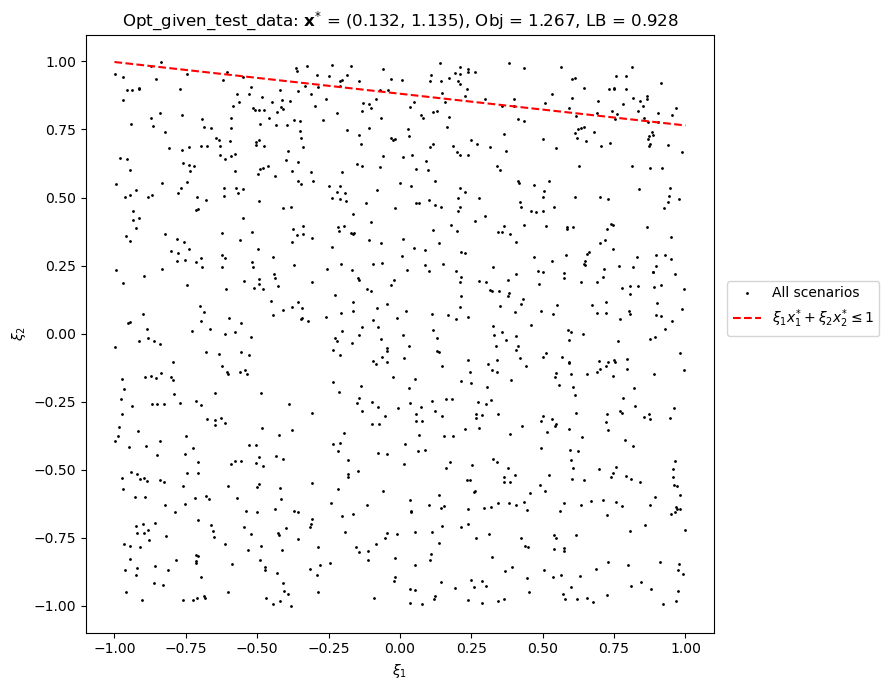

In [11]:
# Plot optimal solution given data_test
name = 'Opt_given_test_data'
save_plot = False
plot_type = "eps"
show_legend = True
plot_solution(name, data_test, None, opt_x, opt_obj, opt_lb, save_plot, plot_type, show_legend)

In [ ]:
# Compute solution via Campi method
data = generate_data(k, N_campi)
runtime, campi_x, campi_obj, campi_true_prob, Z_arr = solve_with_campi_N(alpha, beta, numeric_precision, data, time_limit_mosek)

In [ ]:
# Plot Campi solution
name = 'Campi method'
save_plot = False
plot_type = "eps"
show_legend = True
plot_solution(name, data, Z_arr, campi_x, campi_obj, 0, save_plot, plot_type, show_legend)

In [7]:
# Set parameter values
alpha = 10**-6
beta = 0.9
k = 2
N_test = 1000
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 1
time_limit_solve = 1*60 #in seconds 
time_limit_search = 4
numeric_precision = 1e-6 # To correct for floating-point math operations

# Get generated data
N_campi = determine_campi_N_min(k, beta, alpha)
N_train = N_campi
data_train, data_nominal = generate_data_with_nominal(k, N_train)
data_test = generate_data(k, N_test)

add_strategy = 'smallest_vio'
remove_strategy = 'all_inactive'

Following cells are used to obtain output and write to latex tables

In [ ]:
headers = ['$k$', '$N$', '$N_{test}$', '$N_{cal}$', 'Obj.~(true prob.)', 'Obj.~(given test data)', 'Obj.~Alg.', 
           'Gap (\%)', 'LB', '\#iter', 'Time Alg.', 'Time MIP']

output_data = {}

# Variables parameter values
k_settings = [2, 5, 10]
N_settings = [100, 500, 1000]
N_test_settings = [0.25, 0.5, 0.75] #percentages of N

# Fixed parameter values
remove_cc = False
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 1
alpha = 0.1
beta = 0.9
time_limit_mosek = 10*60 #in seconds 
time_limit_alg = 10*60
numeric_precision = 1e-6 # To correct for floating-point math

# Alg settings
add_strategy = 'smallest_vio'
remove_cc = False
remove_nonbinding = False

for k in k_settings:
    N_cal = compute_calafiore_N_min(k, beta, alpha)
    
    for N in N_settings:
        for N_test_prop in N_test_settings:
            N_test = int(N_test_prop * N)
            
            data, data_nominal, data_test, data_train = generate_data(k, N, N_test)
            
            x_true, obj_true = solve_toymodel_true_prob(beta, k)
            
            runtime_mip, x_mip, sum_y_mip, obj_mip, p_min = compute_opt_given_data(alpha, beta, par, phi_div, data_test, time_limit_mosek)               
            
            runtime_alg, x_alg, obj_alg, lb_alg, true_prob_x_alg, num_iter, Z_arr = solve_with_alg(add_strategy, remove_cc, remove_nonbinding, 
                                                                           alpha, beta, par, phi_div, numeric_precision,
                                                                           data_train, data_test, data_nominal, 
                                                                           time_limit_mosek, time_limit_alg)
            if runtime_mip is None:
                runtime_mip = 0
                obj_mip = 0
                gap_obj = 0
            else:
                gap_obj = 100*(obj_mip - obj_alg)/obj_mip
        
        
            output_data[(k, N, N_test)] = [N_cal, 
                                           f'{round(obj_true,3):.3f}',
                                           f'{round(obj_mip,3):.3f}',
                                           f'{round(obj_alg,3):.3f}', 
                                           f'{round(gap_obj,1):.1f}',
                                           f'{round(lb_alg,3):.3f}', 
                                           num_iter, 
                                           f'{round(runtime_alg, 0):.0f}',
                                           f'{round(runtime_mip, 0):.0f}']
    
write_output_to_latex(3, headers, output_data)